In [ ]:
!pip install -q datasets
!pip install -q bertopic umap-learn hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 8.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-c

In [ ]:
import zipfile
import pandas as pd

from sklearn.model_selection import train_test_split
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
import numpy as np
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Unzip files
zip_review_path = "/content/Baby_Products.csv.zip"
zip_meta_path = "/content/meta_Baby_Products.csv.zip"

with zipfile.ZipFile(zip_review_path, 'r') as zip_ref:
    zip_ref.extractall("/content/")
with zipfile.ZipFile(zip_meta_path, 'r') as zip_ref:
    zip_ref.extractall("/content/")

# Read files
reviews_csv_path = "/content/Baby_Products.csv"
meta_csv_path = "/content/meta_Baby_Products.csv"

# Read data
reviews_df = pd.read_csv(reviews_csv_path)
meta_df = pd.read_csv(meta_csv_path, low_memory=False)

if "reviewText" in reviews_df.columns:
    reviews_df.rename(columns={"reviewText": "text"}, inplace=True)

# Remove empty text
reviews_df = reviews_df.dropna(subset=["text"])
reviews_df["text"] = reviews_df["text"].astype(str)
reviews_df = reviews_df[reviews_df["text"].str.strip() != ""]


The size of the dataset after sampling: 301086


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...



The number of each sentiment category：
label
Positive    2426
Negative     324
Neutral      250
Name: count, dtype: int64
Saved df_sampled_with_labels.csv


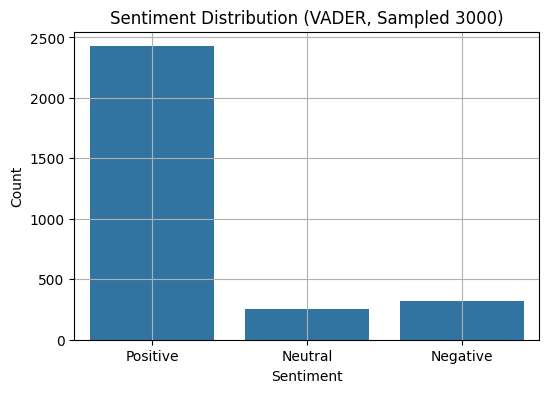

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sampling（5%）
df_sampled = reviews_df.sample(frac=0.05, random_state=42)
print(f"The size of the dataset after sampling: {df_sampled.shape[0]}")

# VADER Sentiment Analysis
nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    score = sia.polarity_scores(str(text))["compound"]
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df_sampled["label"] = df_sampled["text"].apply(get_vader_sentiment)

df_sampled = df_sampled.sample(n=3000, random_state=42)

print("\nThe number of each sentiment category：")
print(df_sampled["label"].value_counts())

# Save data
df_sampled.to_csv("/content/df_sampled_with_labels.csv", index=False)
print("Saved df_sampled_with_labels.csv")

# Visualization
plt.figure(figsize=(6,4))
sns.countplot(x="label", data=df_sampled, order=["Positive", "Neutral", "Negative"])
plt.title("Sentiment Distribution (VADER, Sampled 3000)")
plt.ylabel("Count")
plt.xlabel("Sentiment")
plt.grid(True)
plt.show()

# RQ 1

# Model 1

In [ ]:
from textblob import TextBlob
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Load data
df = pd.read_csv("/content/df_sampled_with_labels.csv")
label_map = {"Negative": 0, "Neutral": 1, "Positive": 2}
df["label_num"] = df["label"].map(label_map)

# TextBlob
def textblob_sentiment(text):
    polarity = TextBlob(str(text)).sentiment.polarity
    if polarity >= 0.05:
        return "Positive"
    elif polarity <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df["tb_label"] = df["text"].apply(textblob_sentiment)
tb_y_true = df["label_num"]
tb_y_pred = df["tb_label"].map(label_map)

tb_acc = accuracy_score(tb_y_true, tb_y_pred)
tb_prec = precision_score(tb_y_true, tb_y_pred, average="weighted")
tb_rec = recall_score(tb_y_true, tb_y_pred, average="weighted")
tb_f1 = f1_score(tb_y_true, tb_y_pred, average="weighted")

print("\n TextBlob Performance:")
print(f"Accuracy   : {tb_acc:.4f}")
print(f"Precision  : {tb_prec:.4f}")
print(f"Recall     : {tb_rec:.4f}")
print(f"F1 Score   : {tb_f1:.4f}")


 TextBlob Performance:
Accuracy   : 0.8233
Precision  : 0.8492
Recall     : 0.8233
F1 Score   : 0.8313


# Model 2

In [ ]:
!wget -q http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip -d glove.6B

import numpy as np
import re, string
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Load data
df = pd.read_csv("/content/df_sampled_with_labels.csv")
label_map = {"Negative": 0, "Neutral": 1, "Positive": 2}
df["label_num"] = df["label"].map(label_map)

# Glove
glove_path = "glove.6B/glove.6B.100d.txt"
embeddings_index = {}
with open(glove_path, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

# Text preprocessing
def preprocess(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"\@w+|\#", "", text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    return text.split()

def get_average_vector(tokens):
    vectors = [embeddings_index[w] for w in tokens if w in embeddings_index]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

tqdm.pandas()
X_vectors = df["text"].progress_apply(lambda x: get_average_vector(preprocess(x)))
X = np.vstack(X_vectors.values)
y = df["label_num"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Model Training
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
glove_y_pred = clf.predict(X_test)

# Evaluate
glove_acc = accuracy_score(y_test, glove_y_pred)
glove_prec = precision_score(y_test, glove_y_pred, average="weighted")
glove_rec = recall_score(y_test, glove_y_pred, average="weighted")
glove_f1 = f1_score(y_test, glove_y_pred, average="weighted")

print("\n GloVe + LogisticRegression Performance:")
print(f"Accuracy   : {glove_acc:.4f}")
print(f"Precision  : {glove_prec:.4f}")
print(f"Recall     : {glove_rec:.4f}")
print(f"F1 Score   : {glove_f1:.4f}")


replace glove.6B/glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


100%|██████████| 3000/3000 [00:00<00:00, 9128.26it/s]



 GloVe + LogisticRegression Performance:
Accuracy   : 0.8317
Precision  : 0.7972
Recall     : 0.8317
F1 Score   : 0.7905


# Model 3

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("/content/df_sampled_with_labels.csv")
df["label_num"] = df["label"].map({"Negative": 0, "Neutral": 1, "Positive": 2})

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["text"].tolist(), df["label_num"].tolist(), test_size=0.2, random_state=42
)

# Tokenizer
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(texts, truncation=True, padding="max_length", max_length=64)

train_encodings = tokenize(train_texts)
test_encodings = tokenize(test_texts)

train_dataset = Dataset.from_dict({
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
    "labels": train_labels
})
test_dataset = Dataset.from_dict({
    "input_ids": test_encodings["input_ids"],
    "attention_mask": test_encodings["attention_mask"],
    "labels": test_labels
})

# Model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="no",
    logging_dir="./logs",
    report_to="none",
    fp16=False
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average="weighted")
    rec = recall_score(labels, preds, average="weighted")
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()
eval_results = trainer.evaluate()

bert_acc = eval_results["eval_accuracy"]
bert_prec = eval_results["eval_precision"]
bert_rec = eval_results["eval_recall"]
bert_f1 = eval_results["eval_f1"]

print("\n DistilBERT Performance:")
print(f"Accuracy   : {bert_acc:.4f}")
print(f"Precision  : {bert_prec:.4f}")
print(f"Recall     : {bert_rec:.4f}")
print(f"F1 Score   : {bert_f1:.4f}")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.441300,0.352577,0.893333,0.888764,0.893333,0.882526
2,0.212400,0.328376,0.891667,0.886492,0.891667,0.887022



 DistilBERT Performance:
Accuracy   : 0.8917
Precision  : 0.8865
Recall     : 0.8917
F1 Score   : 0.8870



 Model Performance Comparison Table:


,Model,Accuracy,Precision,Recall,F1 Score
0,TextBlob,0.8233,0.8492,0.8233,0.8313
1,GloVe + LR,0.8317,0.7972,0.8317,0.7905
2,DistilBERT,0.8917,0.8865,0.8917,0.8870


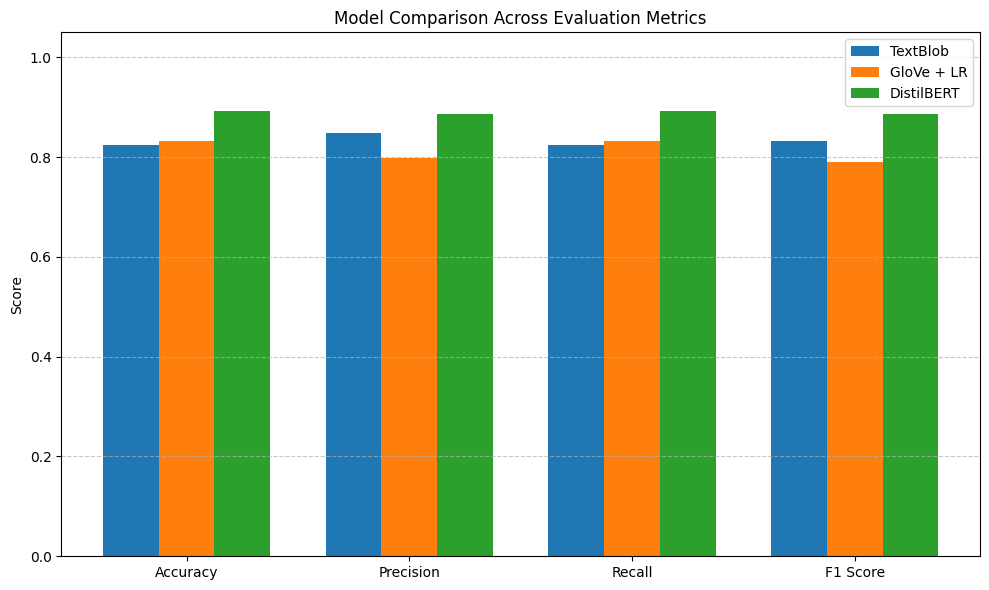

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

results = pd.DataFrame({
    "Model": ["TextBlob", "GloVe + LR", "DistilBERT"],
    "Accuracy": [tb_acc, glove_acc, bert_acc],
    "Precision": [tb_prec, glove_prec, bert_prec],
    "Recall": [tb_rec, glove_rec, bert_rec],
    "F1 Score": [tb_f1, glove_f1, bert_f1]
})

# Print result
print("\n Model Performance Comparison Table:")
display(results.round(4))

# Graph
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
x = np.arange(len(metrics))  # [0, 1, 2, 3]
bar_width = 0.25

scores = results.iloc[:, 1:].values

plt.figure(figsize=(10, 6))

for i in range(len(results)):
    plt.bar(x + i * bar_width, scores[i], width=bar_width, label=results["Model"][i])

plt.xticks(x + bar_width, metrics)
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("Model Comparison Across Evaluation Metrics")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# RQ 2

In [ ]:
# Sampling
df_sampled = reviews_df.sample(n=8000, random_state=42)

# VADER
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download("vader_lexicon")

sia = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    score = sia.polarity_scores(str(text))["compound"]
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df_sampled["label"] = df_sampled["text"].apply(get_vader_sentiment)

# Save file
df_sampled.to_csv("/content/df_sampled_with_labels_for_RQ2.csv", index=False)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


2025-04-06 14:04:36,988 - BERTopic - Embedding - Transforming documents to embeddings.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/250 [00:00<?, ?it/s]

2025-04-06 14:07:53,506 - BERTopic - Embedding - Completed ✓
2025-04-06 14:07:53,507 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-06 14:08:43,599 - BERTopic - Dimensionality - Completed ✓
2025-04-06 14:08:43,609 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-06 14:08:44,261 - BERTopic - Cluster - Completed ✓
2025-04-06 14:08:44,280 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-06 14:08:44,877 - BERTopic - Representation - Completed ✓


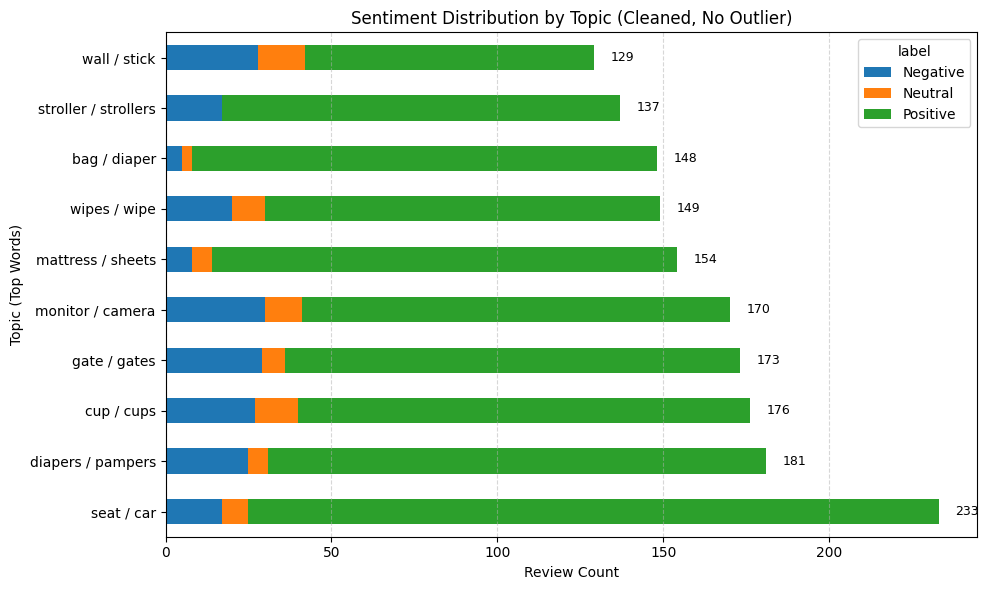

2025-04-06 14:08:46,639 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


 Saved df_sampled_with_labels_and_topics_cleaned.csv
 Saved BERTopic model to /content/final_model


In [ ]:
import pandas as pd
import nltk
from bertopic import BERTopic
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Load file
df = pd.read_csv("/content/df_sampled_with_labels_for_RQ2.csv")

# Text clearning
custom_stopwords = ENGLISH_STOP_WORDS.union({
    "de", "el", "la", "los", "las", "es", "una", "un", "por", "para",
    "muy", "con", "en", "al", "lo", "que", "se", "y", "a", "su", "del", "no", "me",
    "mi", "producto", "como", "más", "pero"
})

def clean_text(text):
    tokens = str(text).lower().split()
    tokens = [word for word in tokens if word not in custom_stopwords]
    return " ".join(tokens)

df["clean_text"] = df["text"].apply(clean_text)
texts = df["clean_text"].astype(str).tolist()

# BERTopic
topic_model = BERTopic(language="english", verbose=True, min_topic_size=10)
topics, _ = topic_model.fit_transform(texts)
df["topic"] = topics

# Remove outlier
df_clean = df[df["topic"] != -1]

# Analyze sentiment
sentiment_dist = df_clean.groupby(["topic", "label"]).size().unstack().fillna(0)

def get_topic_name(topic_id):
    words = topic_model.get_topic(topic_id)
    return " / ".join([w[0] for w in words[:2]])

sentiment_dist.index = [get_topic_name(i) for i in sentiment_dist.index]

# Graph
top_n = 10
top_topics = sentiment_dist.sum(axis=1).sort_values(ascending=False).head(top_n).index

ax = sentiment_dist.loc[top_topics].plot(
    kind="barh",
    stacked=True,
    figsize=(10, 6),
    title="Sentiment Distribution by Topic (Cleaned, No Outlier)"
)
plt.xlabel("Review Count")
plt.ylabel("Topic (Top Words)")
plt.grid(axis='x', linestyle='--', alpha=0.5)

for i, topic in enumerate(top_topics):
    total = sentiment_dist.loc[topic].sum()
    ax.text(total + 5, i, f"{int(total)}", va='center', fontsize=9, color="black")

plt.tight_layout()
plt.show()

df_clean.to_csv("/content/df_sampled_with_labels_and_topics_cleaned.csv", index=False)
print(" Saved df_sampled_with_labels_and_topics_cleaned.csv")

# Save file
topic_model.save("/content/final_model")
print(" Saved BERTopic model to /content/final_model")


# RQ 3

<ipython-input-3-be5afb5778b8>:44: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_meta = pd.read_csv("/content/meta_Baby_Products.csv")


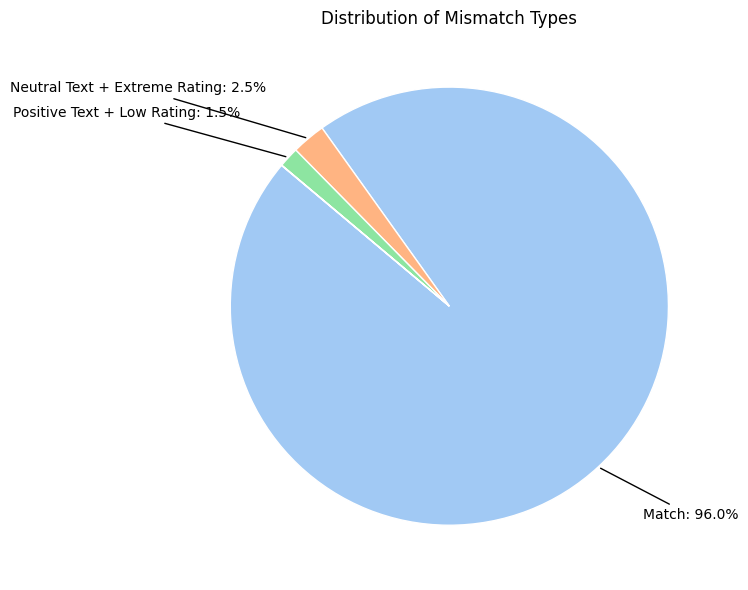

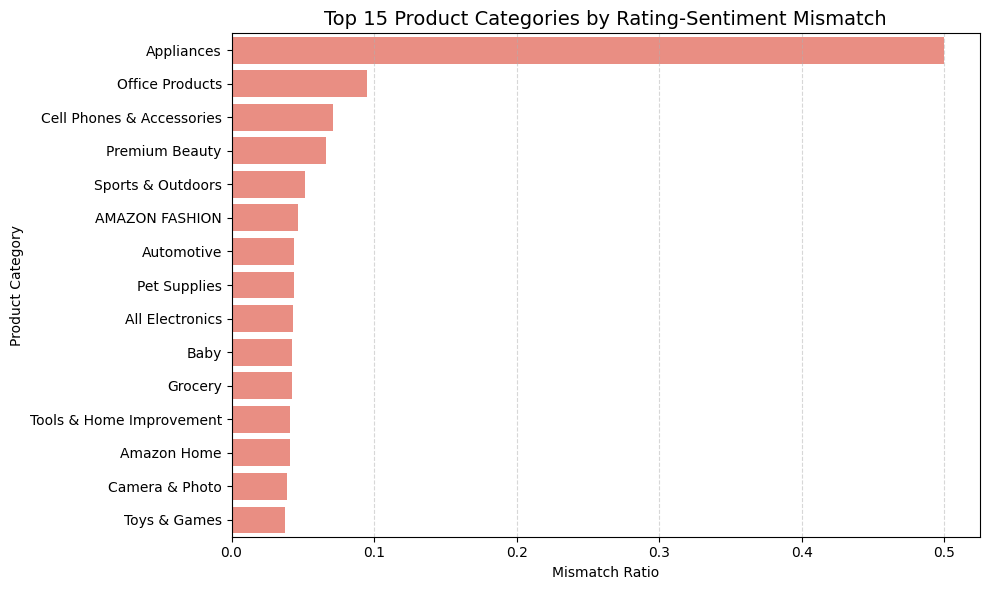

🔍 示例 Mismatch Review:


,text,label,rating,main_category,mismatch_type
277580,good,Positive,3,All Beauty,Positive Text + Low Rating
446532,Excelente,Neutral,5,Baby,Neutral Text + Extreme Rating
77233,love them,Positive,3,NaN,Positive Text + Low Rating
15896,Muy bueno,Neutral,4,Tools & Home Improvement,Neutral Text + Extreme Rating
352830,Good,Positive,1,NaN,Positive Text + Low Rating


 Saved: df_RQ3_combined.csv & category_mismatch_summary.csv


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# Load file
rq2_path = "/content/df_sampled_with_labels_and_topics_cleaned.csv"

df_topics = pd.read_csv(rq2_path)
df_topics = df_topics.sample(n=3000, random_state=42).reset_index(drop=True)

# Clean data
df_reviews = pd.read_csv("/content/Baby_Products.csv")
df_reviews.columns = df_reviews.columns.str.strip().str.lower()

if "asin" not in df_reviews.columns and "parent_asin" in df_reviews.columns:
    df_reviews.rename(columns={"parent_asin": "asin"}, inplace=True)

for col in ["text", "rating", "asin"]:
    if col not in df_reviews.columns:
        raise ValueError(f" df_reviews 缺失字段：{col}")

df_reviews = df_reviews[["text", "rating", "asin"]].dropna()
df_reviews["rating"] = df_reviews["rating"].astype(float).astype(int)

# Merge data
df = df_topics.merge(df_reviews, on="text", how="left", suffixes=('_topics', '_reviews'))

if "rating_reviews" in df.columns and "asin_reviews" in df.columns:
    df.rename(columns={"rating_reviews": "rating", "asin_reviews": "asin"}, inplace=True)

if "asin" not in df.columns:
    raise ValueError(" still missing")

df = df.dropna(subset=["asin"])

# Load file
df_meta = pd.read_csv("/content/meta_Baby_Products.csv")
df_meta.columns = df_meta.columns.str.strip().str.lower()

asin_col = "asin" if "asin" in df_meta.columns else "parent_asin"
if "main_category" not in df_meta.columns:
    raise ValueError(" meta_Baby_Products.csv 缺少 main_category 字段")

df_meta = df_meta[[asin_col, "main_category"]].rename(columns={asin_col: "asin"})
df = df.merge(df_meta, on="asin", how="left")

# Rating-label mismatch
def check_mismatch(row):
    if row["label"] == "Positive" and row["rating"] <= 3:
        return "Mismatch"
    elif row["label"] == "Negative" and row["rating"] >= 4:
        return "Mismatch"
    elif row["label"] == "Neutral" and (row["rating"] <= 2 or row["rating"] >= 4):
        return "Mismatch"
    else:
        return "Match"

df["match_status"] = df.apply(check_mismatch, axis=1)

# Ratio of mismatch
category_summary = df.groupby(["main_category", "match_status"]).size().unstack(fill_value=0)
category_summary["Total"] = category_summary.sum(axis=1)
category_summary["Mismatch Ratio"] = category_summary["Mismatch"] / category_summary["Total"]
category_summary = category_summary.sort_values("Mismatch Ratio", ascending=False).reset_index()

# Graph
def get_mismatch_type(row):
    if row["label"] == "Positive" and row["rating"] <= 3:
        return "Positive Text + Low Rating"
    elif row["label"] == "Negative" and row["rating"] >= 4:
        return "Negative Text + High Rating"
    elif row["label"] == "Neutral" and row["rating"] != 3:
        return "Neutral Text + Extreme Rating"
    else:
        return "Match"

df["mismatch_type"] = df.apply(get_mismatch_type, axis=1)


# Pie chart
type_counts = df["mismatch_type"].value_counts()
labels = type_counts.index.tolist()
sizes = type_counts.values
colors = sns.color_palette("pastel", len(labels))
# Negative text + High Rating is 0

fig, ax = plt.subplots(figsize=(8, 6))
wedges, _ = ax.pie(sizes, startangle=140, colors=colors, wedgeprops=dict(edgecolor='white'))

total = sum(sizes)
for i, (w, label) in enumerate(zip(wedges, labels)):
    percent = sizes[i] / total
    if percent > 0.005:
        angle = (w.theta2 + w.theta1) / 2
        x = np.cos(np.deg2rad(angle))
        y = np.sin(np.deg2rad(angle))
        ha = "left" if x > 0 else "right"
        ax.annotate(f"{label}: {percent:.1%}",
                    xy=(x, y),
                    xytext=(1.3 * x, 1.3 * y),
                    ha=ha, va="center",
                    arrowprops=dict(arrowstyle="-", lw=1),
                    fontsize=10)

ax.set_title("Distribution of Mismatch Types")
plt.tight_layout()
plt.show()

# Bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=category_summary.head(15), x="Mismatch Ratio", y="main_category", color="salmon")
plt.title("Top 15 Product Categories by Rating-Sentiment Mismatch", fontsize=14)
plt.xlabel("Mismatch Ratio")
plt.ylabel("Product Category")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Mismatch example
sample_mismatches = df[df["match_status"] == "Mismatch"][["text", "label", "rating", "main_category", "mismatch_type"]].sample(5, random_state=42)
print("🔍 示例 Mismatch Review:")
display(sample_mismatches)

# Save file
df.to_csv("/content/df_RQ3_combined.csv", index=False)
category_summary.to_csv("/content/category_mismatch_summary.csv", index=False)
print(" Saved: df_RQ3_combined.csv & category_mismatch_summary.csv")
